In [1]:
import tracemalloc
import gc

import os
import sys
sys.path.append(os.path.abspath(os.path.join('../..')))

from reservoirgrid.helpers import chaos_utils

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns

In [2]:
path = "../../Examples/Input_Discretization/results/Chaotic/"
save_path = "../../Examples/Input_Discretization/Plots/SingleMetric/"
system_name = "Lorenz"
system_path = os.path.join(path, system_name)

In [3]:
from natsort import natsorted

all_files = os.listdir(system_path)
files_to_plot = all_files[:]
sort = natsorted([name[:-4] for name in files_to_plot])

In [ ]:
file_labels = []
all_leaky = []
all_lyap = []

def process_entry(entry):
    """Process a single entry and return relevant data or None if fails"""
    try:
        leaky = entry['parameters']['LeakyRate']
        lyap_time = chaos_utils.lyapunov_time(
            truth=entry['true_value'],
            predictions=entry["predictions"],
            method = "threshold"
        )
        return leaky, lyap_time
    except Exception as e:
        print(f"Error processing entry: {e}")
        return None

for i, file in enumerate(sort):
    file_path = os.path.join(system_path, file + ".pkl")
    
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            
            # Process each entry immediately without storing intermediate lists
            for entry in data:
                result = process_entry(entry)
                if result is not None:
                    leaky, lyap_time = result
                    all_leaky.append(leaky)
                    all_lyap.append(lyap_time)
                    file_labels.append(file)

            del data
            del entry
            gc.collect()

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        continue

In [5]:
selection = 1
selected_lyap = all_lyap[::selection]
selected_leaky = all_leaky[::selection]
#selected_spectral = all_spectral[::selection] 
#selected_scaling = all_scaling[::selection]
selected_file_labels = file_labels[::selection]
#selected_divs = all_Kldiv[::selection]

# Create DataFrame with File information
df = pd.DataFrame({
    'LeakyRate': selected_leaky,
    #'SpectralRadius': selected_spectral,
    #'InputScaling': selected_scaling,
    'LyapunovTime': selected_lyap,
    #'KLDivergence' : selected_divs,
    'File': selected_file_labels  # Add file/period information
})

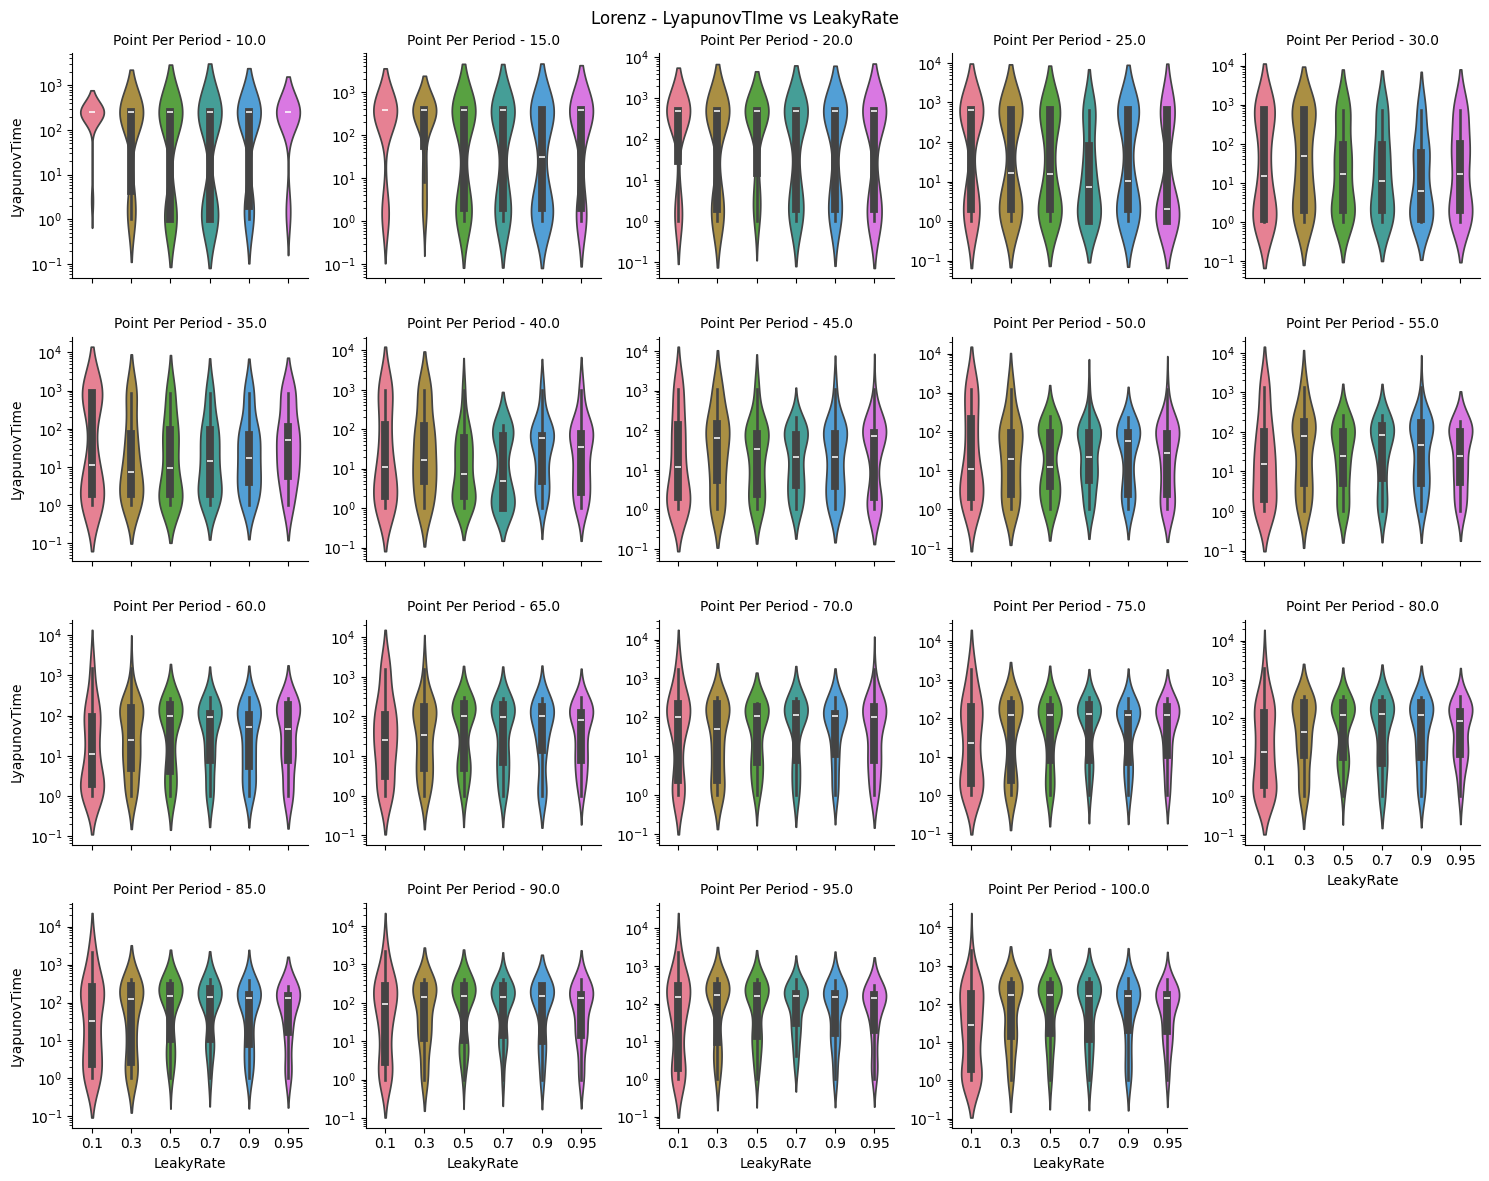

In [10]:
g = sns.FacetGrid(df, col='File', col_wrap=5, height=3, sharey=False)

g.map(sns.violinplot,
    'LeakyRate',
    'LyapunovTime',
    color='lightgray',
    width=0.6,
    order = df["LeakyRate"].unique(),
    hue = df["LeakyRate"],
    palette=sns.color_palette("husl", n_colors=len(df['LeakyRate'].unique())),
    log_scale = True
    #whiskerprops={'linewidth': 2},
    #boxprops={'facecolor': 'lightgray', 'edgecolor': 'black'},
    #medianprops={'color': 'green', 'linewidth': 2}
    )

g.set_titles("Point Per Period - {col_name}")
g.fig.suptitle(f"{system_name} - LyapunovTIme vs LeakyRate")
plt.tight_layout()
plt.savefig(f"{save_path}/{system_name}_LyapunovTime_LeakyRate", dpi = 600)